# Fine-tuning SBERT Model for Similarity Search
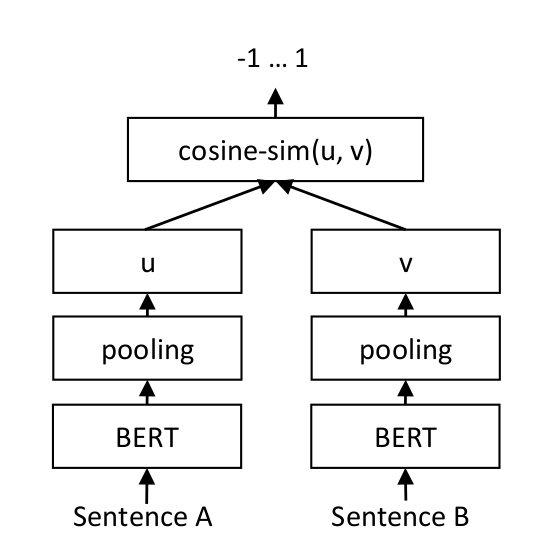

In [ ]:
%%capture
!pip install sentence-transformers datasets

In [ ]:
from sentence_transformers import SentenceTransformer, models

model = SentenceTransformer('msmarco-distilbert-base-tas-b')

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/265M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset

path = '/content/question_answer.csv'
dataset = load_dataset('csv', data_files=path)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(f"- The {path} dataset has {dataset['train'].num_rows} examples.")
# print(f"- Each example is a {type(dataset['train'][0])} with a {type(dataset['train'][0]['set'])} as value.")
print(f"- Examples look like this: {dataset['train'][0]}")

- The /content/question_answer.csv dataset has 809 examples.
- Examples look like this: {'question': 'What is the format of the teaching for the Deep Learning 2023 course?', 'chunk': '02456 Deep learning 2023 - course plan and information Time: Mondays at 13:00-17:00 (first session is August 28th, 2023) Locations: We will use the following rooms - building/room - (Campus map): B303A-A042 B303A-046 B303A-047 B303A-048 B303A-HOEST Zoom (You need to sign-in with you DTU account) We use flipped classroom teaching. During the weeks with labs, the teachers and teaching assistants will circulate between the rooms so there will be opportunity to meet all. Any short lectures/instructions will be repeated in all rooms. You are free to choose whatever room you prefer of course respecting the limits on room capacity. During the weeks with project work each room will cover specific topics. If you are not able to be on campus or prefer to work remotely you will be able to participate through Zoom. O

In [ ]:
from sentence_transformers import InputExample

train_examples = []
train_data = dataset['train']
n_examples = dataset['train'].num_rows

for i in range(n_examples):
  example = train_data[i]
  #print(example['question'], example['chunk'])

  train_examples.append(InputExample(texts=[example['question'], example['chunk']]))

In [ ]:
from sentence_transformers import losses
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(model=model)
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [ ]:
from sentence_transformers import evaluation

#corpus = {"id1": "I am most inclinated", "id2": "I am not inclinated"}
#queries = {"qid": "Is this a fact"}
#relevant_docs = {"qid": ["id1"]}

dev_set = load_dataset('csv', data_files='/content/validation.csv')

dev_data = dev_set['train']
m_examples = dev_set['train'].num_rows

corpus = {}
queries = {}
relevant_docs = {}

for i in range(m_examples):
  example = dev_data[i]
  corpus[str(i)] = example['chunk']
  queries[str(i)] = example['question']
  relevant_docs[str(i)] = [str(i)]

evaluator = evaluation.InformationRetrievalEvaluator(corpus, queries, relevant_docs)

#evaluator = evaluation.InformationRetrievalEvaluator(queries, corpus, relevant_docs)

evaluator.compute_metrices(model)

{'cos_sim': {'accuracy@k': {1: 0.3148148148148148,
   3: 0.5185185185185185,
   5: 0.5740740740740741,
   10: 0.5925925925925926},
  'precision@k': {1: 0.3148148148148148,
   3: 0.17283950617283952,
   5: 0.11481481481481483,
   10: 0.05925925925925927},
  'recall@k': {1: 0.3148148148148148,
   3: 0.5185185185185185,
   5: 0.5740740740740741,
   10: 0.5925925925925926},
  'ndcg@k': {10: 0.46416194696904456},
  'mrr@k': {10: 0.4212962962962963},
  'map@k': {100: 0.4415582448049992}},
 'dot_score': {'accuracy@k': {1: 0.3148148148148148,
   3: 0.46296296296296297,
   5: 0.5370370370370371,
   10: 0.6296296296296297},
  'precision@k': {1: 0.3148148148148148,
   3: 0.15432098765432098,
   5: 0.10740740740740742,
   10: 0.06296296296296297},
  'recall@k': {1: 0.3148148148148148,
   3: 0.46296296296296297,
   5: 0.5370370370370371,
   10: 0.6296296296296297},
  'ndcg@k': {10: 0.4614165753794542},
  'mrr@k': {10: 0.4083333333333333},
  'map@k': {100: 0.42696902262299}}}

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
print(model.encode('What is the meaning of life?'))